In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

### Data Processing

In [3]:
# Supporting Functions

def read_files(folder_path, column_map={}):
    """
    Reads all CSV files in the specified folder and returns as a combined and processed DataFrame.
    """
    dfs = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        df = standardise_columns(df, column_map)
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)

    combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp']) # convert timestamp to datetime format

    return combined_df

def standardise_columns(df, column_map):
    """
    Standardises the column names of a DataFrame based on a provided mapping
    """
    return df.rename(columns={col: column_map[col] for col in df.columns if col in column_map})

In [4]:
# Load data

failure_df  = read_files('failure_data')
scada_df = read_files(os.path.join('supporting_data', 'scada'))

column_map = {
    'TimeDetected': 'Timestamp',
    'Time_Detected': 'Timestamp',
    'TimeReset': 'Time_Reset',
    'UnitTitleDestination': 'Unit_Title_Destination',
    'UnitTitle': 'Turbine_ID',
    'Turbine_Identifier': 'Turbine_ID'
}

logs_df = read_files(os.path.join('supporting_data', 'logs'), column_map)

C:\Users\mes22ss\AppData\Local\Temp\ipykernel_34620\2379978987.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [5]:
# Join scada and failure data based on timestamps

turbine_ids = np.unique(scada_df.Turbine_ID) # unique list of turbines

failure_cols = failure_df.columns.tolist()
scada_cols = scada_df.columns.tolist()

offset = pd.to_timedelta(10, unit='m')
intervals = 12 # number of prior timesteps to include in failure window
failure_windows = [] # list to store failure windows

for id in turbine_ids:
    # select data from each turbine in turn and sort by timestamp
    turbine_data = scada_df.loc[scada_df.Turbine_ID == id].sort_values('Timestamp')
    failure_data = failure_df.loc[failure_df.Turbine_ID == id].sort_values('Timestamp')

    turbine_data = turbine_data.drop_duplicates(subset='Timestamp') # some timestamps appeared to be duplicated

    turbine_data.set_index('Timestamp', inplace=True)

    turbine_data = turbine_data.resample('10min').asfreq()  # resamples the data to fill in missing 10 min intervals

    turbine_data = turbine_data.ffill() # forward fills any missing values -> this could be done differently...

    turbine_data['failure'] = 0 # adds a column to indicate if failure is present (1) or not (0)
    
    for _, row in failure_data.iterrows(): # iterates through each row of the failure data
        mask = (turbine_data.index > row['Timestamp'] - (offset * intervals)) & (turbine_data.index <= row['Timestamp'] + offset) # makes a mask (True/False) if failure is present during 10 min scada window (and prior window)

        for col in failure_cols:
            turbine_data.loc[mask, col + "_failure"] = row[col] # adds the failure df data to the turbine data
            turbine_data.loc[mask, "failure"] = 1 # sets the failure column to 1

        failure_windows.append(turbine_data.loc[mask]) # creates a list of failures data dfs

    # concatenate the data for all turbines
    if id == turbine_ids[0]:
        combined_df = turbine_data.copy()
    else:
        combined_df = pd.concat([combined_df, turbine_data], ignore_index=False)

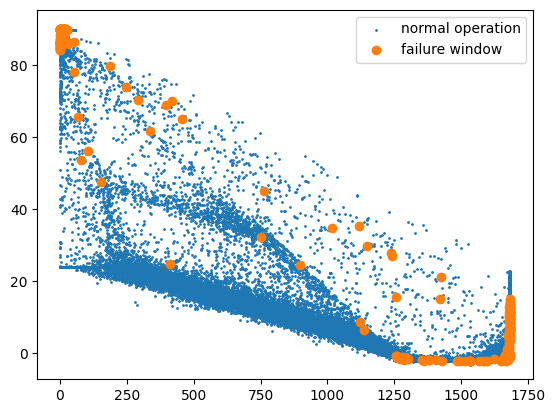

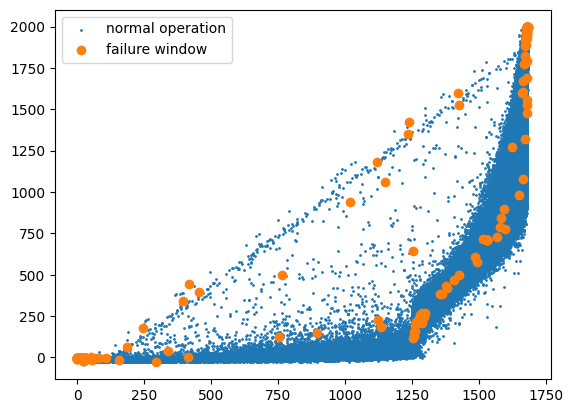

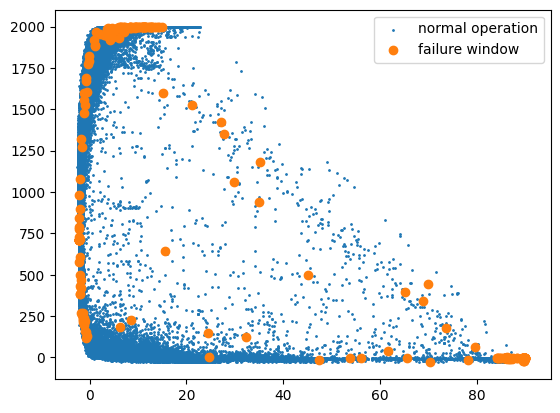

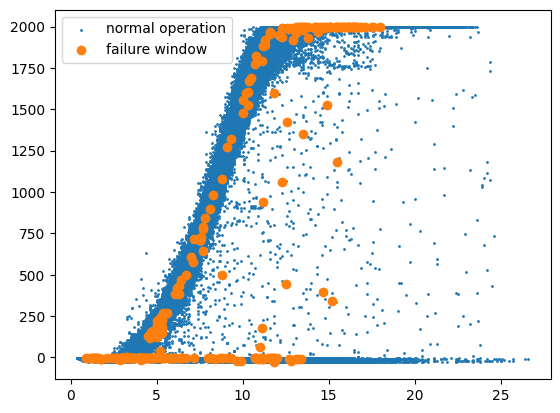

In [6]:
# Exploratory plots

failed = combined_df[combined_df.failure == 1].copy()
normal = combined_df[combined_df.failure == 0].copy()

plt.figure()
plt.scatter(normal.Gen_RPM_Avg, normal.Blds_PitchAngle_Avg, s=1, label="normal operation")
plt.scatter(failed.Gen_RPM_Avg, failed.Blds_PitchAngle_Avg, label="failure window")
plt.legend()
plt.show()

plt.figure()
plt.scatter(normal.Gen_RPM_Avg, normal.Grd_Prod_Pwr_Avg, s=1, label="normal operation")
plt.scatter(failed.Gen_RPM_Avg, failed.Grd_Prod_Pwr_Avg, label="failure window")
plt.legend()
plt.show()

plt.figure()
plt.scatter(normal.Blds_PitchAngle_Avg, normal.Grd_Prod_Pwr_Avg, s=1, label="normal operation")
plt.scatter(failed.Blds_PitchAngle_Avg, failed.Grd_Prod_Pwr_Avg, label="failure window")
plt.legend()
plt.show()

plt.figure()
plt.scatter(normal.Amb_WindSpeed_Avg, normal.Grd_Prod_Pwr_Avg, s=1, label="normal operation")
plt.scatter(failed.Amb_WindSpeed_Avg, failed.Grd_Prod_Pwr_Avg, label="failure window")
plt.legend()
plt.show()

### Data filtering

In [7]:
# Filtering - remove some of the data not pertaining to "normal online operation" -> a smarter more general approach could be used here e.g. using a distance metric to determine outliers such as Mahalanobis distance

filtered_df = combined_df.copy()

capacity = np.max(combined_df.Grd_Prod_Pwr_Avg)

filtered_df['filter1'] = (filtered_df['Blds_PitchAngle_Avg'] > 30).astype(int)

filtered_df['filter2'] = (
    (filtered_df['Grd_Prod_Pwr_Avg'] > 1250) &
    (filtered_df['Gen_RPM_Avg'] < 1500)
).astype(int)

filtered_df['filter3'] = (
    (filtered_df['Blds_PitchAngle_Avg'] > 5) &
    (filtered_df['Grd_Prod_Pwr_Avg'] > 250) & 
    (filtered_df['Grd_Prod_Pwr_Avg'] < 1500)
).astype(int)

filtered_df['filter3'] = (
    (filtered_df['Blds_PitchAngle_Avg'] > 5) &
    (filtered_df['Grd_Prod_Pwr_Avg'] > 250) & 
    (filtered_df['Grd_Prod_Pwr_Avg'] < 1500)
).astype(int)

filtered_df['filter4'] = (
    (filtered_df['Amb_WindSpeed_Avg'] > 14) &
    (filtered_df['Grd_Prod_Pwr_Avg'] < 0.95*capacity)
).astype(int)

filtered_df['filter'] = np.maximum(np.maximum(np.maximum(filtered_df['filter1'], filtered_df['filter2']), filtered_df['filter3']), filtered_df['filter4'])
filtered_df = filtered_df[filtered_df['filter'] == 0]

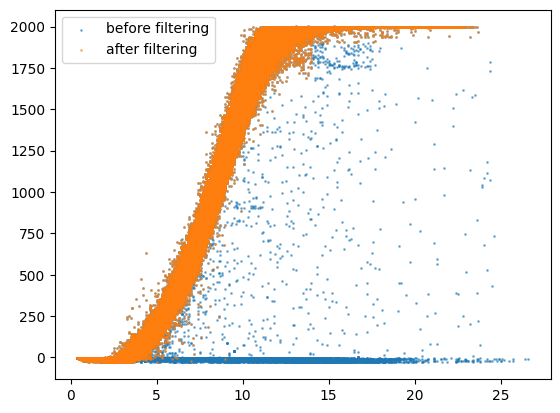

In [8]:
plt.figure()
plt.scatter(combined_df.Amb_WindSpeed_Avg, combined_df.Grd_Prod_Pwr_Avg, s=1, alpha=0.5, label="before filtering")
plt.scatter(filtered_df.Amb_WindSpeed_Avg, filtered_df.Grd_Prod_Pwr_Avg, s=1, alpha=0.5, label="after filtering")

plt.legend()
plt.show()

### Power Curve Model - Gaussian Process Regression

In [9]:
from sklearn.preprocessing import StandardScaler

# Select data for modelling
data = filtered_df[['Amb_WindSpeed_Avg', 'Grd_Prod_Pwr_Avg']].copy()

data = data.sample(frac=0.003, random_state=42) # downsample data to reduce modelling overhead

X = data.Amb_WindSpeed_Avg.values.reshape(-1, 1)
y = data.Grd_Prod_Pwr_Avg.values.reshape(-1, 1)

# Rescale the data
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

X_min = np.min(X)
X_max = np.max(X)

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e1)) + WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-50, 1e1)
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=8)
gpr.fit(X_scaled, y_scaled)

GaussianProcessRegressor(alpha=1e-05,
                         kernel=1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=8)

### Model demonstration

In [11]:
X_test = np.linspace(X_min, X_max, 1000).reshape(-1, 1)
X_test_scaled = x_scaler.transform(X_test)
y_mean_scaled, y_std_scaled = gpr.predict(X_test_scaled, return_std=True)

y_mean_scaled = y_mean_scaled.reshape(-1, 1)
y_std_scaled = y_std_scaled.reshape(-1, 1)

y_mean = y_scaler.inverse_transform(y_mean_scaled)
upper = y_scaler.inverse_transform(y_mean_scaled + 3*y_std_scaled).reshape(-1)
lower = y_scaler.inverse_transform(y_mean_scaled - 3*y_std_scaled).reshape(-1)

Text(0, 0.5, 'Power (kW)')

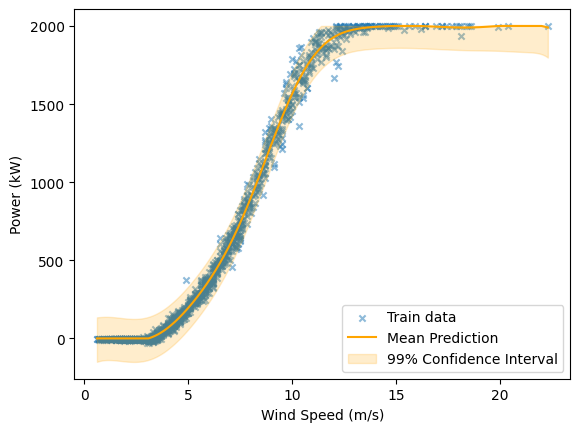

In [12]:
plt.scatter(X,y, label="Train data", marker='x',s=20, alpha=0.5)
plt.plot(X_test, np.maximum(0,np.minimum(y_mean, capacity)), label="Mean Prediction",c="orange")
plt.fill_between(X_test.reshape(-1), lower, np.minimum(upper, capacity), alpha=0.2, label="99% Confidence Interval",color="orange")

plt.legend()
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power (kW)")

### Example time series prediction

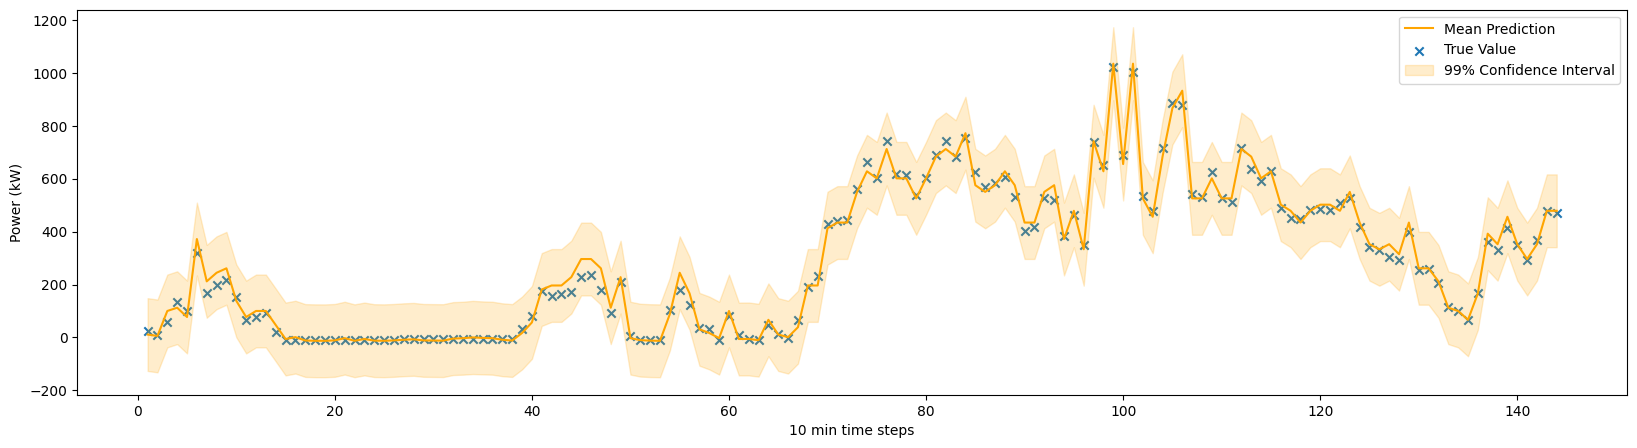

In [13]:
# Example time series prediction
time_df = combined_df[combined_df.Turbine_ID == "T01"].copy()

hours = 24
num_data = hours * 6

X_true = time_df.Amb_WindSpeed_Avg.values.reshape(-1, 1)[0:num_data]
y_true = time_df.Grd_Prod_Pwr_Avg.values.reshape(-1, 1)[0:num_data]

X_true_scaled = x_scaler.transform(X_true)
y_true_scaled = y_scaler.transform(y_true)

y_pred_scaled, y_pred_std_scaled = gpr.predict(X_true_scaled, return_std=True)
y_pred_scaled = y_pred_scaled.reshape(-1, 1)
y_pred_std_scaled = y_pred_std_scaled.reshape(-1, 1)

y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_upper = y_scaler.inverse_transform((y_pred_scaled + 3*y_pred_std_scaled)).reshape(-1)
y_lower = y_scaler.inverse_transform((y_pred_scaled - 3*y_pred_std_scaled)).reshape(-1)

plt.figure(figsize=(20, 5))

plt.plot(np.linspace(1,len(X_true),len(X_true)), y_pred, label="Mean Prediction", c="orange")
plt.scatter(np.linspace(1,len(X_true),len(X_true)), y_true, label="True Value",marker="x")
plt.fill_between(np.linspace(1,len(X_true),len(X_true)), y_lower, y_upper, alpha=0.2, label="99% Confidence Interval",color="orange")

plt.legend()
plt.xlabel("10 min time steps")
plt.ylabel("Power (kW)")
plt.show()

### Time series prediction prior to, and at failure events

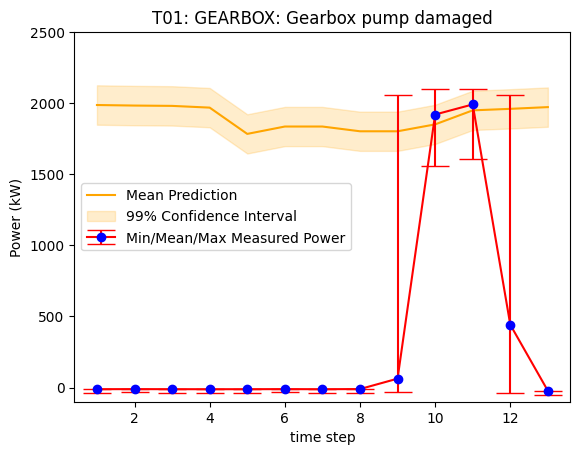

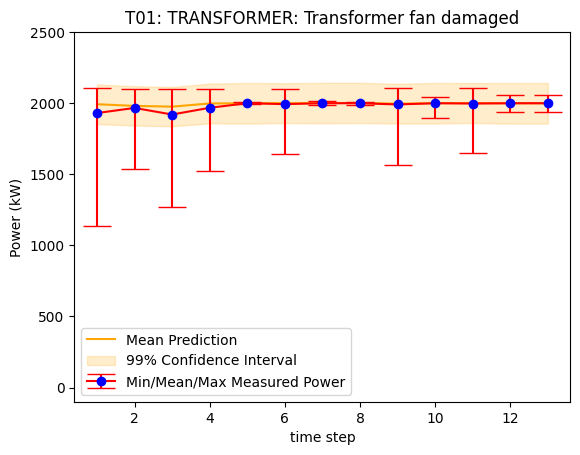

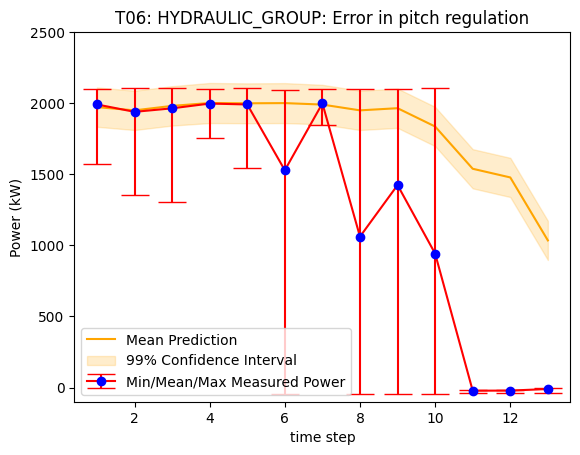

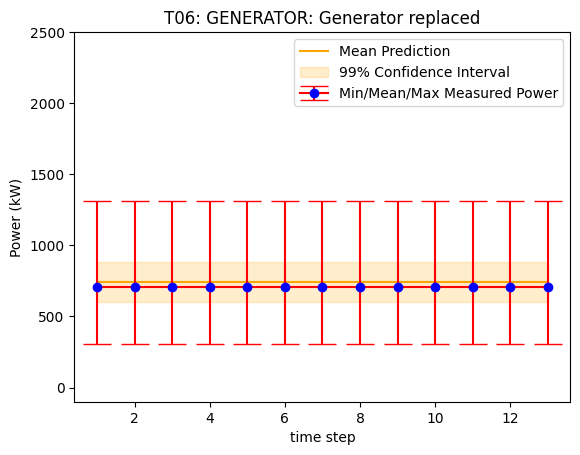

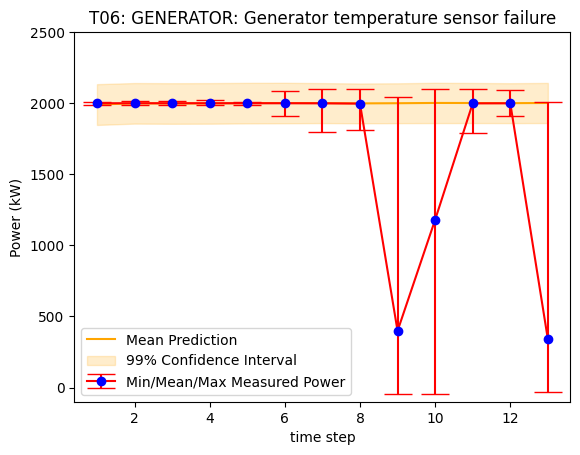

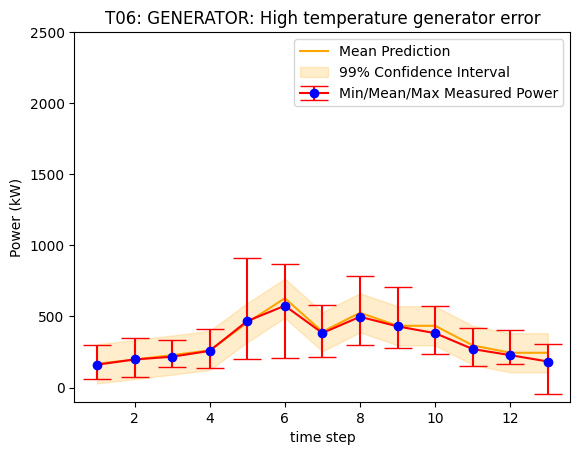

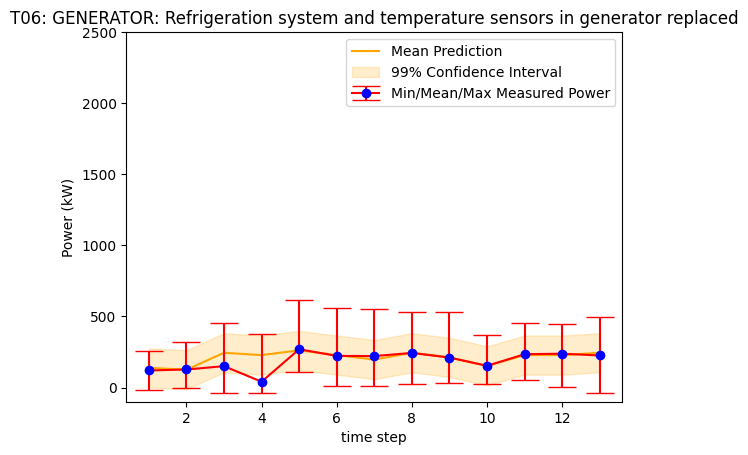

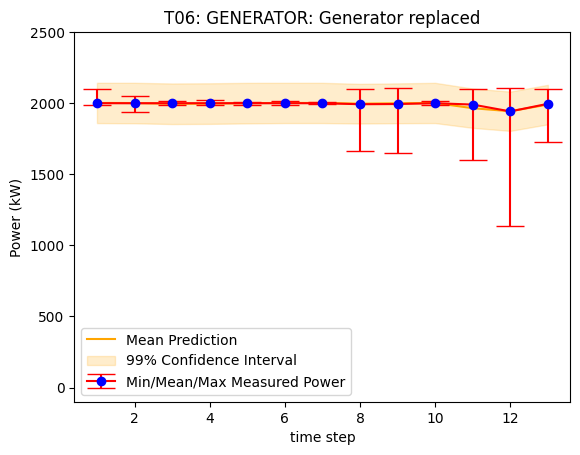

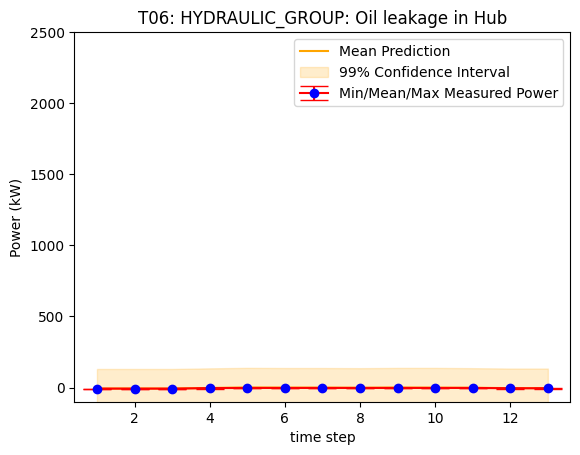

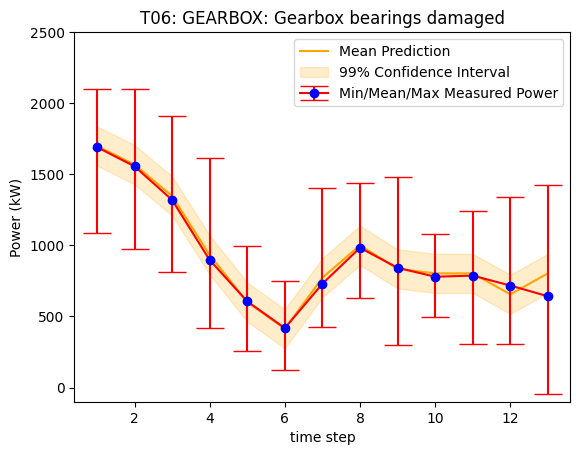

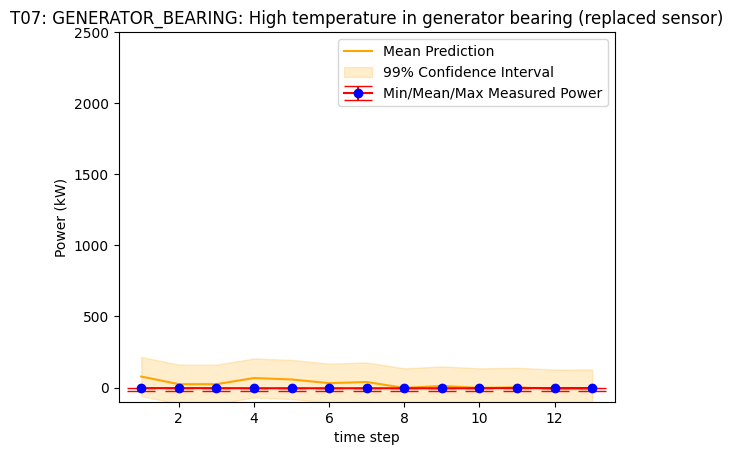

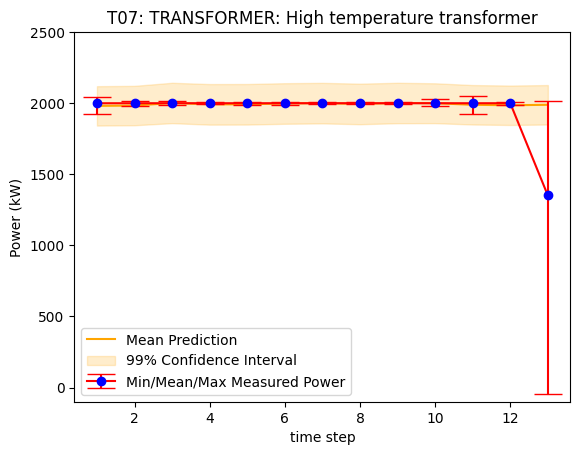

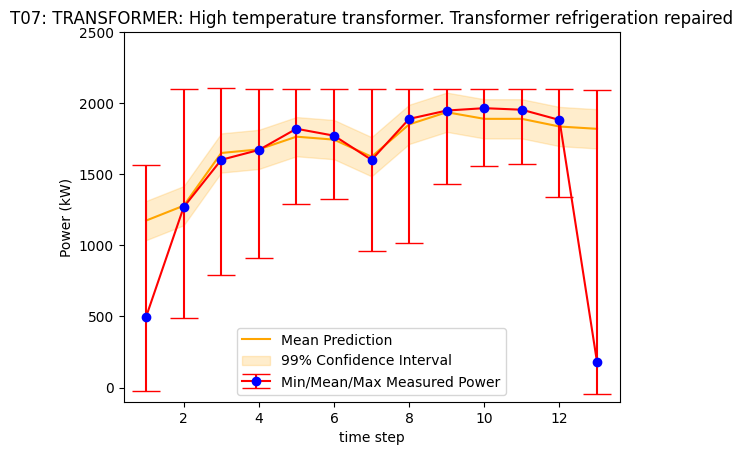

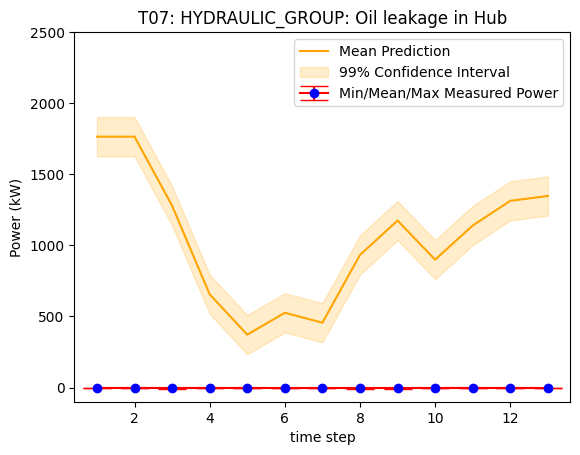

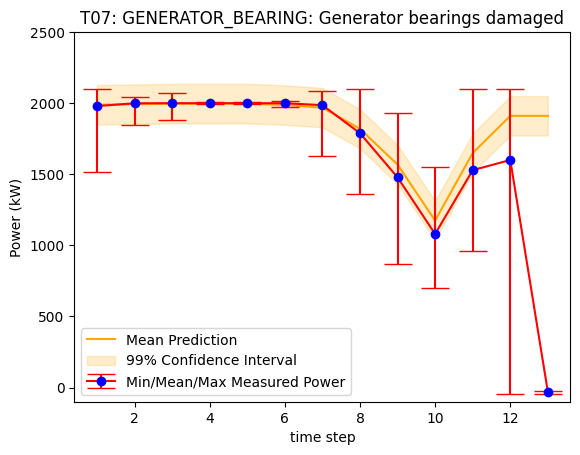

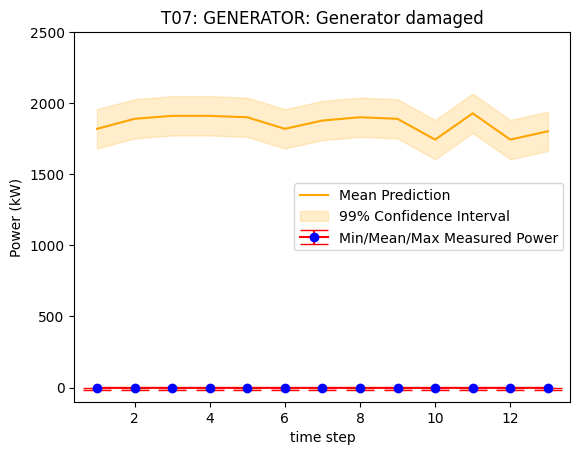

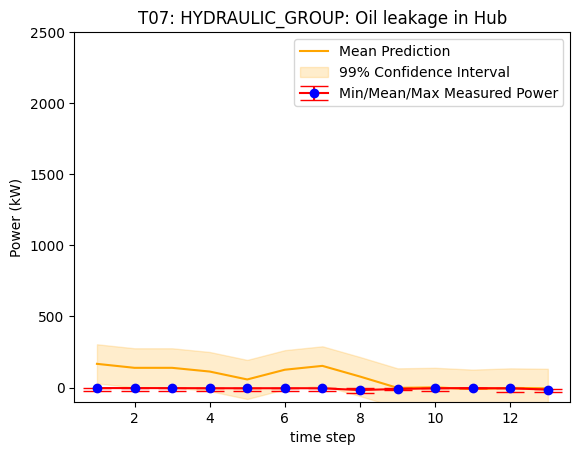

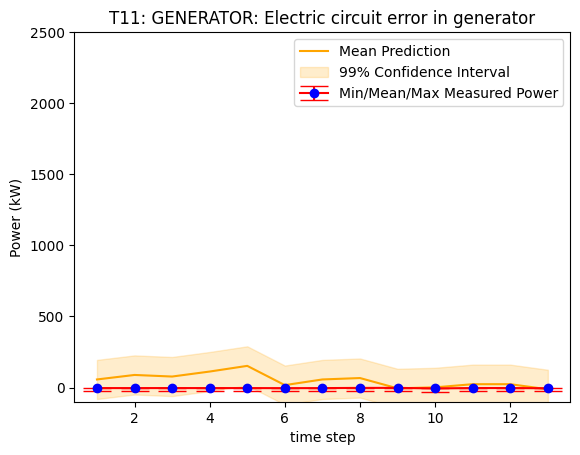

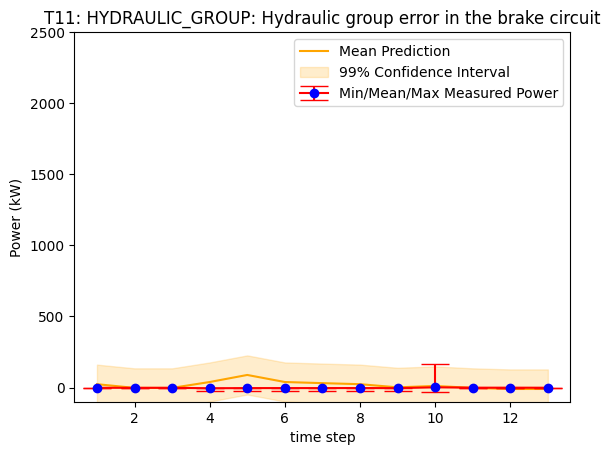

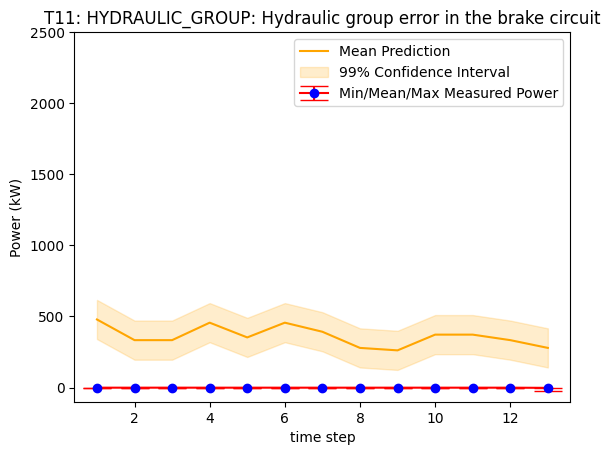

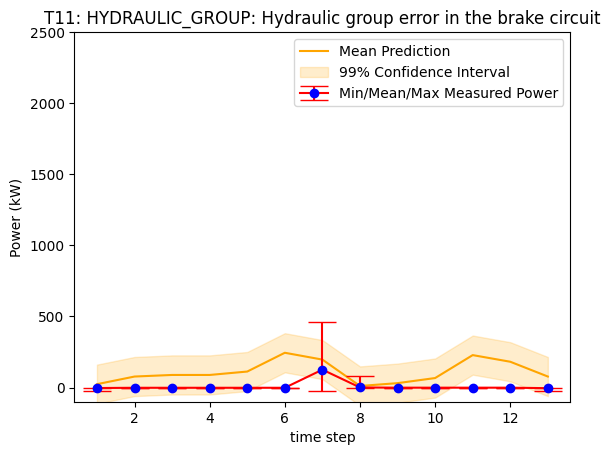

In [14]:
# Time series prediction during failure events

for f in failure_windows:

    X_true = f.Amb_WindSpeed_Avg.values
    y_true = f.Grd_Prod_Pwr_Avg.values

    y_true_min = f.Grd_Prod_Pwr_Min.values
    y_true_max = f.Grd_Prod_Pwr_Max.values

    X_true_scaled = x_scaler.transform(X_true.reshape(-1, 1))
    y_true_scaled = y_scaler.transform(y_true.reshape(-1, 1))

    y_pred_scaled, y_pred_std_scaled = gpr.predict(X_true_scaled, return_std=True)
    y_pred_scaled = y_pred_scaled.reshape(-1, 1)
    y_pred_std_scaled = y_pred_std_scaled.reshape(-1, 1)

    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_upper = y_scaler.inverse_transform((y_pred_scaled + 3*y_pred_std_scaled)).reshape(-1)
    y_lower = y_scaler.inverse_transform((y_pred_scaled - 3*y_pred_std_scaled)).reshape(-1)

    plt.figure()
    plt.plot(np.linspace(1,len(X_true),len(X_true)), y_pred, label="Mean Prediction", c="orange")

    plt.errorbar(np.linspace(1,len(X_true),len(X_true)), y_true, yerr=[y_true - y_true_min, y_true_max - y_true], marker='o',markerfacecolor='blue', markeredgecolor='blue', linestyle='-', color='red', capsize=10, label="Min/Mean/Max Measured Power")
    plt.fill_between(np.linspace(1,len(X_true),len(X_true)), y_lower, y_upper, alpha=0.2, label="99% Confidence Interval",color="orange")

    plt.legend()
    plt.xlabel("time step")
    plt.ylabel("Power (kW)")
    plt.ylim(-100,2500)
    plt.title(str(f.Turbine_ID_failure.values[0]) + ": " + str(f.Component_failure.values[0]) + ": " + str(f.Remarks_failure.values[0]))
    plt.show()

Notes:

Plots show 12 time steps before each failure in each case (the 2 hours before), followed by the time step during which failure occurred.

Some of these failures have trends in the power data prior to the time step in which the failure occurred (step 13 in each case). For others, it appears as though the turbine was offline at the time of failure, for which monitoring power is not suitable. The approach taken here may be applied to any pair of variables, although it would work better as an anomaly detector if there is clear correlation between the variables, so tighter uncertainty bounds can be learned. The approach can also easily be extended to the multivariate case by supplying a multi-dimensional input X.
